---
### Coupling two probability distributions with high probability of equality  
---

**Course:** *Simulation and Monte Carlo Methods* (2nd Semester, ENSAE Paris)  
**Authors:** Piero PELOSI, Omar EL MAMOUNE, Sarakpy NY  
**Supervisor:** Yvann LE FAY

---

In [5]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import importlib

In [14]:
import utils.rejection_coupling as rc
importlib.reload(rc)

<module 'utils.rejection_coupling' from '/Users/pieropelosi/MCProject.Coupling/utils/rejection_coupling.py'>

In [15]:
import utils.thorisson as thorisson
importlib.reload(thorisson)

<module 'utils.thorisson' from '/Users/pieropelosi/MCProject.Coupling/utils/thorisson.py'>

---
#### I. Quick introduction

Given two probability distributions $p$ and $q$, we are interested in constructing a joint distribution (coupling) for $(X,Y)$ such that $X \sim p$, $Y \sim q$, and $P(X=Y)$ is as large as possible. The paper [*The Coupled Rejection Sampler*](https://arxiv.org/abs/2201.09585) proposes a method to achieve this goal and shows how it can be applied to the case of two multivariate Gaussian distributions with different covariance matrices.

This project consists in implementing the proposed approach and comparing it with a simpler, classical algorithm known as Thorisson’s algorithm (Appendix 1 in the paper). We will explain why Thorisson’s algorithm is valid, how it relates to rejection sampling, and then examine several scenarios of increasing dimension. Since the running time of these algorithms is itself a random variable, we will also comment on its distribution and practical implications.

If time permits, we may additionally explore how such a coupling can be embedded in a random-walk Metropolis setting (as in Section 5.3 of the reference paper), and attempt to replicate some of those experiments. 

---
#### II. The coupled rejection-sampling method

Let $p$ and $q$ be two probability densities defined on $\chi$. We define a diagonal coupling of $p$ and $q$ in the following way.

**Definition 1** (Diagonal coupling). *A pair of random variables $(X, Y)$ defined on the same probability space and taking values in $\chi$ is a diagonal coupling of the probability densities $p$ and $q$ if and only if it is a coupling, that is, if*

$$
\mathbb{P}(X \in A) = \int_A p(x)\,dx, \quad \mathbb{P}(Y \in A) = \int_A q(x)\,dx,
$$

*for all measurable sets $A \subset \chi$, and if $\mathbb{P}(X = Y) > 0$.*

With this definition, a maximal coupling (Thorisson, 2000; Lindvall, 2002) is a diagonal coupling with maximal mass on the diagonal event $\{X = Y\}$.

In order to construct the acceptance-rejection scheme, we need the following definition.

**Definition 2** (Dominating pair). *Let $(\hat{p}, \hat{q})$ be a pair of probability densities. We say that it dominates $(p, q)$ (or that $(p, q) \preceq (\hat{p}, \hat{q})$) if and only if there exists $1 \leq M(p, \hat{p}) < \infty$ and $1 \leq M(q, \hat{q}) < \infty$ such that for any $x \in \mathbb{R}^d$ we have*

$$
p(x) \leq M(p, \hat{p})\, \hat{p}(x), \quad q(x) \leq M(q, \hat{q})\, \hat{q}(x).
$$

Now, suppose that we have a diagonal coupling $\hat{\Gamma}$ of $\hat{p}$ and $\hat{q}$ dominating the independent coupling $(p \otimes q)(x, y) = p(x)\, q(y)$. It turns out that we can produce samples from a diagonal coupling $\Gamma$ with marginals $p$ and $q$ by using an acceptance-rejection scheme with the coupling $\hat{\Gamma}$ as the proposal. 

Algorithm **1** shows how to do this and will be implemented below.

<div align="center">
    <img src="pseudo-code/RejectionCoupling.algo.png" alt="Rejection-coupling of (p,q)" width="600"/>
</div>

In [8]:
def rejection_coupling(p, q, hat_p, hat_q, sample_hat_gamma, sample_pq, M_p, M_q):
    A_x, A_y = 0, 0                          # Acceptance flags

    while A_x == 0 and A_y == 0:
        X1, Y1 = sample_hat_gamma()          # Sample from diagonal coupling hat_Gamma
        U = np.random.uniform(0, 1)

        if U < p(X1) / (M_p * hat_p(X1)):
            A_x = 1
        if U < q(Y1) / (M_q * hat_q(Y1)):
            A_y = 1

    X2, Y2 = sample_pq()                     # Sample from independent p ⊗ q

    X = A_x * X1 + (1 - A_x) * X2
    Y = A_y * Y1 + (1 - A_y) * Y2

    return X, Y

**Testing and Visualization**

We implemented the rejection coupling method using Gaussian target distributions $p = \mathcal{N}(0, 1)$ and $q = \mathcal{N}(0, 4)$. The coupling uses an auxiliary distribution $\hat{\gamma} = \hat{p} \otimes \hat{q}$, with $\hat{p}, \hat{q} \sim \mathcal{N}(0, \hat{\sigma}^2)$, where $\hat{\sigma} = 2.5$. The constants $M_p$ and $M_q$ are derived from the ratio of the variances.

Although the independent sampler from $p \otimes q$ (i.e., `sample_pq`) will be updated later in the project, we use a placeholder version for the sake of early experimentation and visualization. This allows us to gain visual insights into the behavior of the rejection mechanism and understand how it builds a coupling between the two marginals. We also track the approximate match rate $|X - Y| < \epsilon$ for interpretability.

Approximate matches (|X - Y| < 0.1): 29/1000 (2.90%)


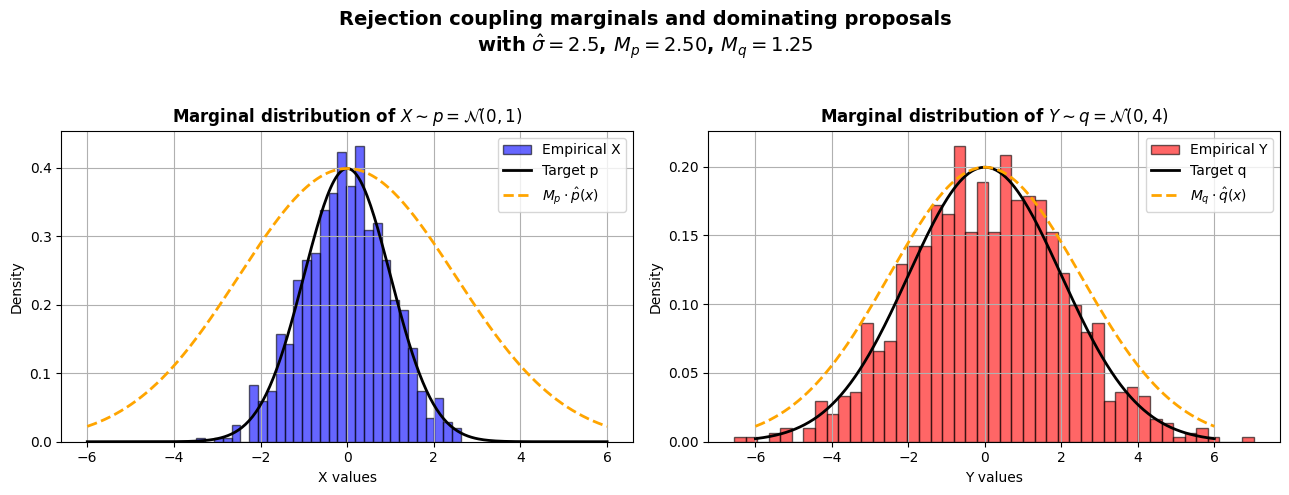

In [9]:
from utils.rejection_coupling import run_rejection_coupling, plot_rejection_coupling

X_values, Y_values, matches, percentage = run_rejection_coupling(rejection_coupling)
plot_rejection_coupling(X_values, Y_values)

---
#### III. The ensemble coupled rejection-sampling method

As mentioned in **Section 2**, the success probability of the coupling defined by Algorithm 1 is highly dependent on the acceptance probability of the marginal rejection subroutine. In fact, if the latter goes to $0$ (which is typically the case when the dimension of the sampling space increases), the former will too. Thankfully, in *Deligiannidis et al. (2020)*, the authors introduce an ensemble rejection sampler which increases the acceptance probability of a rejection-sampling algorithm by considering not one, but several proposals. Formally, if pRS is the probability of accepting a sample in the classical rejection sampling algorithm, then their ensemble rejection-sampler with $N$ proposals has probability $p_{ERS} \geq \frac{Np_{RS}}{1 + (N - 1)p_{RS}}$ to result in an accepted sample (Deligiannidis et al., 2020, Proposition $1$).

In order to do so, the authors form the self-normalized importance sample 
$$\sum_{i=1}^{N} W_i \delta_{X_i}$$
where $X_i \sim \hat{p}, i = 1, \ldots, N$ are i.i.d., 
$w_i = \frac{p(X_i)}{\hat{p}(X_i)}$, 
$W_i = \frac{w_i}{\sum_{j=1}^{N} w_j}$ for $i = 1, \ldots, N$. 

When this is done, they sample $I$ from a categorical distribution 
$\text{Cat}((W_i)_{i=1}^{N})$, and then accept the proposal $X_I$ with probability

$$
\frac{\sum_{i=1}^{N} w_i}{M(p, \hat{p}) + \sum_{i \ne I} w_i}.
$$

In order to improve the acceptance rate of Algorithm 1, we could decide to replace the rejection sampling step by the ensemble rejection sampling one and *Propositions 1 and 2* would essentially remain unchanged. However, in practice, sampling I and J independently from the categorical distributions corresponding to the p and q component, respectively, would not result in a large probability for the event $I = J$, even if the corresponding weights are close and using common random numbers.

Thankfully, it is easy to sample from a maximal coupling of multinomial distributions (see, e.g., *Thorisson, 2000, Section 4.2*), and we can therefore write a coupled version of the ensemble rejection sampler. This is summarized in Algorithm 2.

In the remainder of this section, all the quantities $X$, $Y$, $P(X= Y)$ and $P(I= J)$ implicitly depend on the number of proposals N in the sampled ensemble. However, we do not notationally emphasize this dependency for the sake of readibility.

**Algorithm 2** 

<p align="center">
  <img src="pseudo-code/EnsembleRejectionCoupling.algo.png" alt="Rejection-coupling of (p,q)" width="600"/>
</p>

In [10]:
def ensemble_rejection_coupling(Gamma, p, q, p_hat, M_p, M_q, N, sample_from_pq, maximal_coupling_categorical):
    A_X, A_Y = 0, 0                     # Acceptance flags

    while A_X == 0 and A_Y == 0:
        # Sample from the coupling
        X_hat, Y_hat = zip(*[Gamma() for _ in range(N)])
        X_hat = np.array(X_hat)
        Y_hat = np.array(Y_hat)
        U = np.random.rand()

        # Compute weights
        w_X = np.array([p(xi) / p_hat(xi) for xi in X_hat])
        w_Y = np.array([q(yi) / p_hat(yi) for yi in Y_hat])
        Z_hat_X = np.mean(w_X)
        Z_hat_Y = np.mean(w_Y)

        W_X = w_X / (N * Z_hat_X)   
        W_Y = w_Y / (N * Z_hat_Y)

        # Sample from the maximal coupling
        I, J = maximal_coupling_categorical(W_X, W_Y)

        # Compute acceptance probabilities
        Z_bar_X = Z_hat_X + (M_p - w_X[I]) / N
        Z_bar_Y = Z_hat_Y + (M_q - w_Y[J]) / N

        X_1 = X_hat[I]
        Y_1 = Y_hat[J]

        # Acceptance criteria
        if U < Z_hat_X / Z_bar_X:
            A_X = 1
        if U < Z_hat_Y / Z_bar_Y:
            A_Y = 1
    
    # Sample from independent p ⊗ q
    X_2, Y_2 = sample_from_pq()

    # Combine samples
    X = A_X * X_1 + (1 - A_X) * X_2
    Y = A_Y * Y_1 + (1 - A_Y) * Y_2
    
    return X, Y

---
#### IV. The multidimensional Gaussian case

Our goal is to use **Algorithm 1** to sample from a coupling of $\mathcal{N}(\mu_p, \Sigma_p)$ and $\mathcal{N}(\mu_q, \Sigma_q)$, where the Gaussians have **different means and covariances**.

To do this, we use a *maximal coupling* between Gaussians that share a *common covariance matrix* $\hat{\Sigma}$ as the proposal $\hat{\Gamma}$, following the method of Bou-Rabee et al. (2020), known as the **reflection-maximal coupling**. The algorithm is presented in *Appendix D* and will be implemented later.

To ensure that $\hat{\Gamma}$ is a *diagonal dominating coupling*, the covariance matrix $\hat{\Sigma}$ must satisfy, in the sense of Loewner ordering:

- $\hat{\Sigma}^{-1} \preceq \Sigma_p^{-1}$
- $\hat{\Sigma}^{-1} \preceq \Sigma_q^{-1}$

Under these conditions, for all $x$ we have:

$$
\mathcal{N}(x; \mu_p, \Sigma_p) \leq \frac{\det(2\pi \hat{\Sigma})^{1/2}}{\det(2\pi \Sigma_p)^{1/2}} \, \mathcal{N}(x; \mu_p, \hat{\Sigma})
$$

and similarly:

$$
\mathcal{N}(x; \mu_q, \Sigma_q) \leq \frac{\det(2\pi \hat{\Sigma})^{1/2}}{\det(2\pi \Sigma_q)^{1/2}} \, \mathcal{N}(x; \mu_q, \hat{\Sigma})
$$

This shows that $\mathcal{N}(\mu_p, \hat{\Sigma})$ and $\mathcal{N}(\mu_q, \hat{\Sigma})$ are **dominant proposals** for $p$ and $q$ respectively. 

*Note*: We assume throughout that all covariance matrices $\Sigma_p$, $\Sigma_q$, and $\hat{\Sigma}$ are **symmetric positive definite (SPD)**. This ensures that the inverses and determinants used in the coupling construction are well-defined, and that the Loewner ordering $\hat{\Sigma}^{-1} \preceq \Sigma^{-1}$ is meaningful.

> **Proposition 5** — *Gaussian diagonal coupling via a dominating covariance matrix*
> 
> Let $\hat{\Sigma}$ be a covariance matrix with $\hat{\Sigma}^{-1} \preceq \Sigma_p^{-1}$ and $\hat{\Sigma}^{-1} \preceq \Sigma_q^{-1}$, and let $\hat{\Gamma}$ be a reflection-maximal coupling of $\mathcal{N}(\mu_p, \hat{\Sigma})$ and $\mathcal{N}(\mu_q, \hat{\Sigma})$.  
> 
> Setting the domination constants:
> 
> $$
> M(p, \hat{p}) = \frac{\det(2\pi \hat{\Sigma})^{1/2}}{\det(2\pi \Sigma_p)^{1/2}}, \quad 
> M(q, \hat{q}) = \frac{\det(2\pi \hat{\Sigma})^{1/2}}{\det(2\pi \Sigma_q)^{1/2}},
> $$
> 
> Algorithm 1, applied to $\hat{\Gamma}$, $\mathcal{N}(\mu_p, \Sigma_p)$, and $\mathcal{N}(\mu_q, \Sigma_q)$, returns a diagonal coupling of $\mathcal{N}(\mu_p, \Sigma_p)$ and $\mathcal{N}(\mu_q, \Sigma_q)$.


In [27]:
def is_spd(matrix):
    """Check if a matrix is symmetric positive definite (SPD)."""
    return np.allclose(matrix, matrix.T) and np.all(np.linalg.eigvalsh(matrix) > 0)

In [28]:
def domination_constants(sigma_hat, sigma_p, sigma_q):
    """
    Compute domination constants M(p, p̂) and M(q, q̂) for a diagonal dominating covariance matrix.
    
    Parameters:
        sigma_hat (ndarray): Common dominating covariance matrix (Σ̂).
        sigma_p (ndarray): Covariance matrix of p (Σ_p).
        sigma_q (ndarray): Covariance matrix of q (Σ_q).
        
    Returns:
        tuple: (M_p, M_q) as defined by dominant ratios.
    """
    if not all(is_spd(mat) for mat in [sigma_hat, sigma_p, sigma_q]):
        raise ValueError("One of the covariance matrices is not symmetric positive definite (SPD).")

    factor = 2 * np.pi
    det_hat = np.linalg.det(factor * sigma_hat)
    det_p   = np.linalg.det(factor * sigma_p)
    det_q   = np.linalg.det(factor * sigma_q)
    
    M_p = np.sqrt(det_hat) / np.sqrt(det_p)
    M_q = np.sqrt(det_hat) / np.sqrt(det_q)
    
    return M_p, M_q

An important aspect of the algorithm is the suitable selection of $\hat{\Sigma}$ so that the coupling probability is as high as possible. Although $\hat{\Sigma}_{\text{max}} = \max([\sigma(\Sigma_p), \sigma(\Sigma_q)]) I_d$ is one possible choice for $\hat{\Sigma}$, it might not be a good choice in practice as it may result in a low acceptance probability.

However, a suitable criterion for maximising the chance of coupling is to simply maximize $\mathbb{P}(A_X = 1) \, \mathbb{P}(A_Y = 1)$. 

As functions of $\hat{\Sigma}^{-1}$, the logarithms of marginal acceptance probabilities are both of the form 
$\frac{1}{2} \log \det(\hat{\Sigma}^{-1}) + \text{constant}$, and therefore a suitable optimisation problem for $\hat{\Sigma}^{-1}$ is:

$$
\begin{array}{ll}
\displaystyle \max_{\hat{\Sigma}^{-1}} & \log \det(\hat{\Sigma}^{-1}) \\
\text{s.t.} & \hat{\Sigma}^{-1} \preceq \Sigma_p^{-1}, \quad 
              \hat{\Sigma}^{-1} \preceq \Sigma_q^{-1}, \quad 
              \hat{\Sigma}^{-1} \succeq 0
\end{array}
$$

> **Proposition 7.** — A solution to the maximisation problem is given by
> 
> $$
> \hat{\Sigma}_{\text{opt}} = C V U V^\top C^\top
> $$
> 
> where $C = \Sigma_q^{1/2}$, $V D V^\top = C^\top \Sigma_p^{-1} C$ is such that $V$ is orthonormal and $D$ is diagonal, and $U$ is diagonal with $U_{ii} = 1/\min(1, D_{ii})$ for all $i$.


*How do we compute $\Sigma_q^{1/2}$?* 

In linear algebra, $\Sigma_q^{1/2}$ refers to any matrix $C$ such that:

$$
C C^\top = \Sigma_q.
$$

*Recall*: If $\Sigma_q$ is SPD, then the **Cholesky decomposition** gives: $\Sigma_q = C C^\top$, where $C$ is a lower triangular matrix with positive diagonal entries. We then use the Cholesky decomposition to compute such a $C$ because it is **fast**, **numerically stable**, and **uniquely defined** for SPD matrices.


In [29]:
def compute_sigma_opt(sigma_p, sigma_q):
    """
    Compute the optimal dominating covariance matrix 
    𝛴̂_opt = C V U Vᵗ Cᵗ, as given in Proposition 7.

    Parameters:
        sigma_p (ndarray): Covariance matrix Σ_p (must be SPD)
        sigma_q (ndarray): Covariance matrix Σ_q (must be SPD)

    Returns:
        ndarray: Optimal covariance matrix 𝛴̂_opt
    """
    if not is_spd(sigma_p) or not is_spd(sigma_q):
        raise ValueError("Input matrices must be symmetric positive definite (SPD).")

    # Let C = Σ_q^{1/2} via Cholesky (Σ_q = C Cᵗ)
    C = np.linalg.cholesky(sigma_q)

    # Compute D and V from spectral decomposition of Cᵗ Σ_p^{-1} C
    sigma_p_inv = np.linalg.inv(sigma_p)
    Q = C.T @ sigma_p_inv @ C
    D_vals, V = np.linalg.eigh(Q)  # M = V D Vᵗ

    # Construct U with U_ii = 1 / min(1, D_ii)
    U_vals = 1 / np.minimum(1, D_vals)
    U = np.diag(U_vals)

    # Compute Σ̂_opt = C V U Vᵗ Cᵗ
    sigma_opt = C @ V @ U @ V.T @ C.T

    return sigma_opt

Now, what remains is to compute $\hat{\Gamma}$, the *diagonal dominating coupling*. This is the final missing piece required to apply **Algorithm 1** to $\hat{\Gamma}$, $\mathcal{N}(\mu_p, \Sigma_p)$, and $\mathcal{N}(\mu_q, \Sigma_q)$, and thereby obtain a diagonal coupling of $\mathcal{N}(\mu_p, \Sigma_p)$ and $\mathcal{N}(\mu_q, \Sigma_q)$.

This coupling is known as the **reflection-maximal coupling**, and its implementation is provided below.

<div align="center">
    <img src="pseudo-code/ReflectionMaximalCoupling.png" alt="Rejection-coupling of (p,q)" width="600"/>
</div>

In [30]:
def reflection_maximal_coupling(mu_p, mu_q, sigma_hat):
    return None

---
#### V. Thorisson algorithm
In this section, we implement the following version of the *Modified Thorisson algorithm*, found in the appendix, page 31.

<div align="center">
    <img src="pseudo-code/Thorisson.algo.png" alt="Modified Thorisson algorithm" width="600"/>
</div>

In [16]:
from utils.thorisson import run_thorisson_coupling, analyze_matches, plot_results

In [17]:
def thorisson_coupling(sample_p, pdf_p, sample_q, pdf_q, C):
    X = sample_p()
    U = np.random.uniform(0, 1)
    if U < min((pdf_q(X) / pdf_p(X)), C):
        Y = X
    else:
        A = 0
        while A != 1:
            U = np.random.uniform(0, 1)
            Z = sample_q()
            if U > min(1, C * pdf_p(Z) / pdf_q(Z)):
                A = 1
            Y = Z
    return X, Y

Number of matches (X = Y): 681 out of 1000.
Percentage of matches: 68.10%.


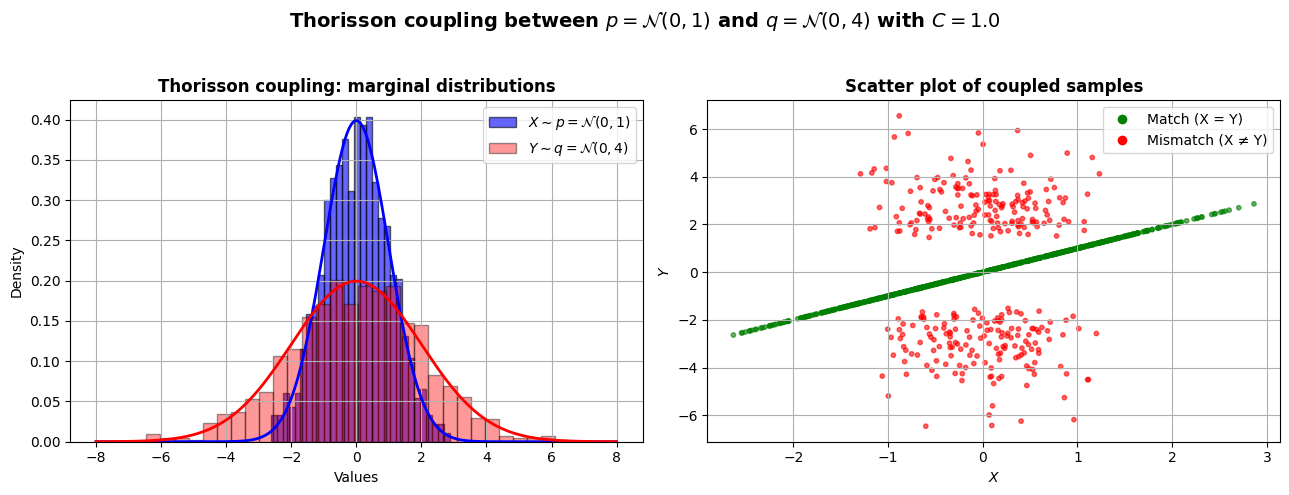

In [18]:
# Set parameters
mu_p, sigma_p = 0.0, 1.0
mu_q, sigma_q = 0.0, 2.0
C = 1.0
n = 1000

# Define the distributions
np.random.seed(87)

sample_p = lambda: norm(loc=mu_p, scale=sigma_p).rvs()
pdf_p = lambda x: norm(loc=mu_p, scale=sigma_p).pdf(x)
sample_q = lambda: norm(loc=mu_q, scale=sigma_q).rvs()
pdf_q = lambda x: norm(loc=mu_q, scale=sigma_q).pdf(x)

# Generate the samples
X_values, Y_values = run_thorisson_coupling(n, thorisson_coupling, sample_p, pdf_p, sample_q, pdf_q, C)

# Analyze the match results
matches, match_count, match_percentage = analyze_matches(X_values, Y_values)

# Print and plot the results
print(f"Number of matches (X = Y): {match_count} out of {n}.")
print(f"Percentage of matches: {match_percentage:.2f}%.")
plot_results(X_values, Y_values, matches, mu_p, sigma_p, mu_q, sigma_q, C)

*Why is Thorisson’s algorithm valid? How does it relates to rejection sampling?*


# Modified Thorisson Algorithm – Intuitive and Rigorous Explanation

## Overview of the Algorithm and Its Components

The **modified Thorisson algorithm** aims to construct a **coupling** between two given probability distributions: a distribution $ p $ (for the variable $ X $) and a distribution $ q $ (for the variable $ Y $). A *coupling* means that the pair $ (X, Y) $ is defined on the same probability space such that the marginal distribution of $ X $ is $ p $ and that of $ Y $ is $ q $. The algorithm guarantees that $ X \sim p $ and $ Y \sim q $, while introducing a specific dependence between $ X $ and $ Y $ (they are generally *not* independent) in order to make the event $ X = Y $ as likely as possible.

### Distributions $ p $ and $ q $

These are the target marginal distributions for $ X $ and $ Y $. We assume that $ p $ and $ q $ are defined on the same state space (e.g., $ \mathbb{R} $ or a common discrete set), and that they are **mutually dominated** by each other. That is, there exists a finite constant $ C $ such that for all states $ x $:

$$
q(x) \le C\,p(x) \quad \text{and} \quad p(x) \le C\,q(x)
$$

This constant $ C $ serves as a **dominating constant** similar to the bound used in classical rejection sampling.

### Random variables

- $ X \sim p $ : initial draw which may be used for both $ X $ and $ Y $ if coupling succeeds.
- $ U \sim \mathcal{U}(0,1) $ : for accept/reject decision.
- $ Z \sim q $ : used in rejection sampling if direct coupling fails.

---

## Step-by-Step Breakdown

### Step 1: Sample $ X \sim p $

This is the fixed value of $ X $. It is never discarded and ensures $ X \sim p $.

### Step 2: Sample $ U \sim \mathcal{U}(0,1) $

This variable will be compared to a threshold based on the densities of $ p $ and $ q $.

### Step 3: Attempt to accept $ X $ as $ Y $

We check whether:

$$
U < \min\left( \frac{q(X)}{p(X)},\; C \right)
$$

If true, set $ Y = X $. This is a **direct coupling** step.

### Step 4: If rejection occurs, switch to rejection sampling for $ Y $

Loop:

- While not accepted:
  - Sample $ U' \sim \mathcal{U}(0,1) $
  - Sample $ Z \sim q $
  - Accept $ Z $ if:

$$
U' > \min\left(1,\; C \cdot \frac{p(Z)}{q(Z)} \right)
$$

If accepted, set $ Y = Z $. Exit loop.

---

## Why This Algorithm is Correct (Theoretical Justification)

We verify that:

- $ X \sim p $
- $ Y \sim q $

Let:

- $ E_1 $: first branch was used (i.e. $ Y = X $)
- $ E_2 $: rejection loop was used

### Case 1: $ E_1 $

On event $ E_1 $, $ Y = X $, and:

$$
\Pr(Y \in B \cap E_1) = \int_{x \in B} \min\{q(x), C p(x)\} \, dx
$$

### Case 2: $ E_2 $

On event $ E_2 $, $ Y \sim q $ via rejection:

$$
\Pr(Y \in B \cap E_2) = \int_{x \in B} \left(q(x) - \min\{q(x), C p(x)\} \right) dx
$$

### Total

Adding both parts:

$$
\Pr(Y \in B) = \int_{x \in B} q(x) \, dx
$$

Hence, $ Y \sim q $ and $ X \sim p $. The output $ (X, Y) $ is a valid coupling.

---

## Link to Rejection Sampling

### First branch = direct accept

The condition:

$$
U < \frac{q(X)}{C p(X)}
$$

is exactly that of standard rejection sampling for generating $ q $ from proposal $ p $.

### Second branch = rejection sampling fallback

This loop performs rejection sampling from $ q $ for the residual part:

$$
q_{\text{rest}}(x) \propto q(x) - C p(x)
$$

with acceptance condition:

$$
U' > \frac{p(Z)}{C q(Z)}
$$

---

## Summary

The modified Thorisson algorithm:

- Builds a coupling $ (X, Y) \sim (p, q) $
- Uses rejection sampling both directly (to couple $ X = Y $) and indirectly (to sample fresh $ Y $ when needed)
- Ensures marginals $ X \sim p $, $ Y \sim q $
- Is efficient and theoretically sound
- Can be tuned via $ C $ to balance coupling probability vs. rejection cost
